In [58]:
# Importación de librerias necesarias para analisis y modelado
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [74]:

# Cargar los datos historicos de las acciones de Domino's
df = pd.read_csv('Dominos_Stock_Data.csv')
print(df.head())
df.info()
df['Date'] = pd.to_datetime(df['Date'])  # Convertimos la fecha al formato correcto
df.set_index('Date', inplace=True)       # Usamos la fecha como indice de la tabla

         Date    Open    High     Low   Close  Adj Close  Volume
0  2019-10-16  254.89  257.61  253.08  255.96     251.60  525200
1  2019-10-17  256.12  259.96  255.78  256.45     252.09  515100
2  2019-10-18  257.45  258.40  254.23  255.70     251.35  609900
3  2019-10-21  256.61  259.84  255.67  257.52     253.14  499600
4  2019-10-22  257.27  259.47  255.38  258.94     254.53  343100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       505 non-null    object 
 1   Open       505 non-null    float64
 2   High       505 non-null    float64
 3   Low        505 non-null    float64
 4   Close      505 non-null    float64
 5   Adj Close  505 non-null    float64
 6   Volume     505 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.7+ KB


In [60]:
# Nos enfocamos únicamente en la columna 'Adj Close' (precio de cierre ajustado)
data = df[['Adj Close']].values

In [61]:

# Escalamos los datos al rango [0, 1] para facilitar el entrenamiento del modelo
escalador = MinMaxScaler()
data_escalada = escalador.fit_transform(data)

In [62]:

# Función para crear las secuencias de entrada y salida para el modelo LSTM
def crear_secuencias(data, ventana):
    X, y = [], []
    for i in range(ventana, len(data)):
        X.append(data[i-ventana:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [63]:

# Definimos una ventana de 10 dias para observar el historial
tam_ventana = 10
X, y = crear_secuencias(data_escalada, tam_ventana)

In [64]:
# Separamos los datos en entrenamiento y prueba (80% - 20%)
división = int(len(X) * 0.8)
X_entrenamiento, X_prueba = X[:división], X[división:]
y_entrenamiento, y_prueba = y[:división], y[división:]

In [65]:
# Definimos el modelo LSTM
modelo = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_entrenamiento.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:

# Compilamos el modelo con el optimizador Adam y pérdida MSE
modelo.compile(optimizer='adam', loss='mean_squared_error')
modelo.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:

# Entrenamos el modelo durante 20 epochs
historial = modelo.fit(X_entrenamiento, y_entrenamiento, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 0.0986 - val_loss: 0.0095
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0173 - val_loss: 0.0220
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0084 - val_loss: 0.0033
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0056 - val_loss: 0.0078
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

In [68]:
# Hacemos predicciones sobre los datos de prueba
predicciones = modelo.predict(X_prueba)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


In [69]:
# Invertimos la escala para obtener los valores reales
predicciones_reales = escalador.inverse_transform(predicciones)
y_reales = escalador.inverse_transform(y_prueba)

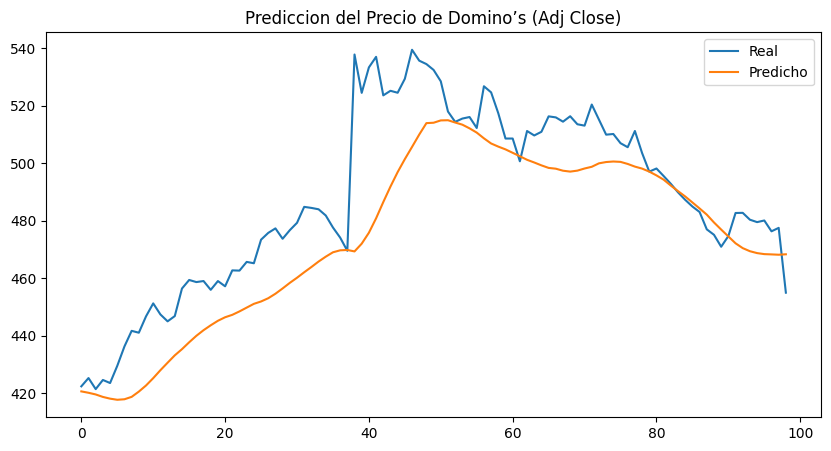

In [70]:
# Visualizamos el resultado
plt.figure(figsize=(10, 5))
plt.plot(y_reales, label='Real')
plt.plot(predicciones_reales, label='Predicho')
plt.title('Prediccion del Precio de Domino’s (Adj Close)')
plt.legend()
plt.show()

In [71]:
# Prediccion especifica del precio para el día 11

# Tomamos los primeros 10 dias para predecir el precio del dia siguiente
ultimos_10_dias = data_escalada[:10]
entrada = ultimos_10_dias.reshape((1, 10, 1))  # Reshape para que el modelo lo entienda

# Hacemos la prediccion
prediccion_escalada = modelo.predict(entrada)
precio_dia_11 = escalador.inverse_transform(prediccion_escalada)

print(f"Prediccion del precio de cierre ajustado para el dia 11: {precio_dia_11[0][0]:.2f} USD")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediccion del precio de cierre ajustado para el dia 11: 266.68 USD
